![](pngs/nba_ml.png)
1. Define Foundation
2. Machine Learning (ML)
---

### ➤ 1 Define Foundation 

In [1]:
import os
import h5py
import matplotlib.colors as col
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             balanced_accuracy_score, confusion_matrix,
                             f1_score, make_scorer,
                             matthews_corrcoef, precision_score, recall_score,
                             roc_auc_score, roc_curve)
from sklearn.model_selection import GridSearchCV, StratifiedKFold


In [2]:
DATA_PATH = r"C:\Users\knaue\Documents\Data\NBA"
NBA_HDF5_PATH = os.path.join(DATA_PATH, "NBA_Season_ML_Data.hdf5")
NBA_CURRENT_SEASON_PATH = os.path.join(DATA_PATH, "NBA_Current_Season_Predictions.csv")
NBA_CURRENT_SEASON_ISO_PATH = os.path.join(DATA_PATH, "NBA_Current_Season_Iso_Predictions.csv")
NBA_FI_SEASON_PATH = os.path.join(DATA_PATH, "NBA_FI_Season.csv")
RANDOM_SEED = 12345

color_turbo = sns.color_palette("turbo")
color_Cha_vs_NoCha = [color for i, color in enumerate(color_turbo) if i in [2,5]]
color_Cha_vs_NoCha.reverse()

In [3]:
def show_all_metrics(test_predict, test_predict_proba, test_labels):
    
    print("Accuracy: ", format(accuracy_score(test_labels, test_predict), '.3f'))
    print("Balanced Accuracy: ", balanced_accuracy_score(test_labels, test_predict))
    print("Recall: ", recall_score(test_labels, test_predict))
    print("Precision: ", precision_score(test_labels, test_predict))
    print("F1: ", f1_score(test_labels, test_predict))
    print("MCC: ", matthews_corrcoef(test_labels, test_predict))
    
    
    roc_auc = roc_auc_score(test_labels, test_predict_proba)
    clf_fpr, clf_tpr, _ = roc_curve(test_labels, test_predict_proba)
    
    fig = plt.figure()
    plt.plot(clf_fpr, clf_tpr, linestyle='-', color='blue', label=f"AUC-SCORE: {format(roc_auc, '.3f')}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-Curve")
    plt.legend()
    plt.show()
    
    label_predictions = dict() 
    label_predictions['y_true'] = test_labels.tolist()
    label_predictions['y_pred'] = test_predict.tolist()

    cm = confusion_matrix(y_true=label_predictions['y_true'], y_pred=label_predictions['y_pred'], labels=[0,1])
    disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    fig = disp_cm.plot().figure_.get_figure()
    plt.show()
        

In [4]:
def read_hd5f(path: str):
    with h5py.File(path, "r") as f:
        train_features = f["Train"]["features"][:] 
        train_labels = f["Train"]["labels"][:] 
        
        test_features = f["Test"]["features"][:]
        test_labels = f["Test"]["labels"][:]
        
        curr_season_features = f["Predict"]["features"][:]
        curr_season_team =  [name.decode('utf-8-sig') for name in f["Predict"]["teams"][:] ]
        curr_season_original_features = f["Predict"]["original_features"][:]
        curr_season_original_columns = [name.decode('utf-8-sig') for name in f["Predict"]["original_columns"][:] ]
        
        header_names = [name.decode('utf-8-sig') for name in f["Foundation"]["header_names"][:] ]
        label_names = [name.decode('utf-8-sig') for name in f["Foundation"]["label_names"][:] ]
        
        return train_features, train_labels, test_features, test_labels, curr_season_features, curr_season_team, curr_season_original_features, curr_season_original_columns, header_names, label_names

In [5]:
def plot_unique_labels(x_labels):
    unique_value, unique_count = np.unique(x_labels, return_counts=True)
    unique_labels = [[value, count] for value, count in zip(unique_value,unique_count)]

    df_explore_data = pd.DataFrame(data=unique_labels, columns= ['Label', 'Count'], index=None)

    fig = plt.figure(figsize = (4, 4))
    ax = sns.barplot(data=df_explore_data, x="Label", y="Count")
    ax.bar_label(ax.containers[0])
    ax.set_xticklabels(label_names)
    plt.ylabel('Count', fontsize=12)
    plt.xlabel('', fontsize=12)
    plt.title(f"Explore Train-Data", fontsize=12)
    plt.show()

### ➤ 2 Machine Learning (ML) -> Results
- Sampling train data 
- Find the best classifier and evaluate its decision making

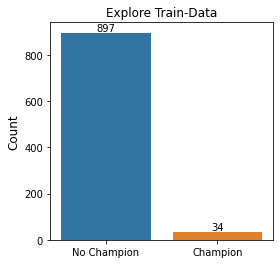

In [6]:
train_features, train_labels, test_features, test_labels, curr_season_features, curr_season_team, curr_season_original_features, curr_season_original_columns, header_names, label_names = read_hd5f(NBA_HDF5_PATH)
plot_unique_labels(train_labels)

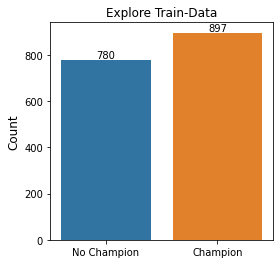

In [7]:
smote = SMOTEENN(random_state=RANDOM_SEED)
train_features, train_labels = smote.fit_resample(train_features, train_labels)
plot_unique_labels(train_labels)

Finding best hyper-parameters for: recall --------------------------
Best parameters:  {'class_weight': 'balanced', 'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 35}
Best score:  1.0
Accuracy:  0.931
Balanced Accuracy:  0.9041666666666667
Recall:  0.875
Precision:  0.3181818181818182
F1:  0.4666666666666667
MCC:  0.5033547516730947


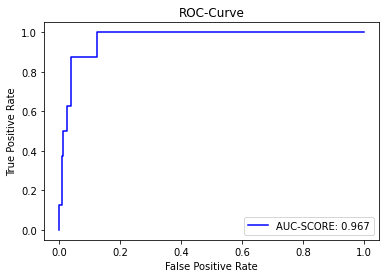

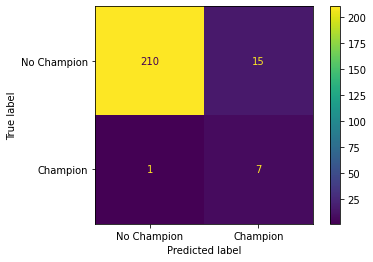

-----------------------------------------------------------------
Finding best hyper-parameters for: balanced_accuracy --------------------------
Best parameters:  {'class_weight': None, 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 30}
Best score:  0.9950390189520624
Accuracy:  0.961
Balanced Accuracy:  0.9197222222222222
Recall:  0.875
Precision:  0.4666666666666667
F1:  0.608695652173913
MCC:  0.6228082193994762


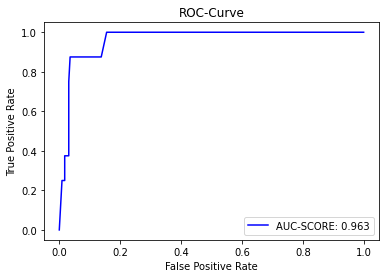

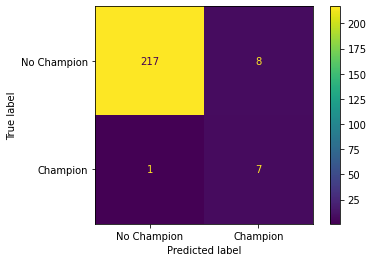

-----------------------------------------------------------------
Finding best hyper-parameters for: make_scorer(matthews_corrcoef) --------------------------
Best parameters:  {'class_weight': None, 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 40}
Best score:  0.9904259437826749
Accuracy:  0.957
Balanced Accuracy:  0.9175
Recall:  0.875
Precision:  0.4375
F1:  0.5833333333333334
MCC:  0.6012192393234924


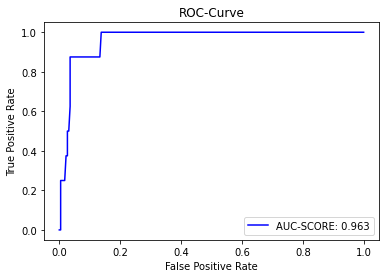

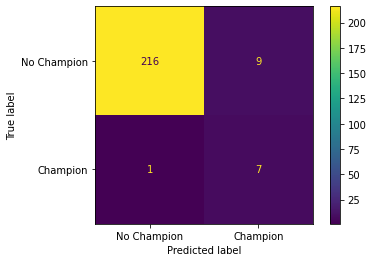

-----------------------------------------------------------------


In [8]:
clf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-3)

param = {
    "class_weight": ["balanced", None],
    "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20],
    "n_estimators": [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    "min_samples_split": [2]
}

for score in ['recall', 'balanced_accuracy', make_scorer(matthews_corrcoef)]:
    grid_search = GridSearchCV(estimator=clf,
                               param_grid=param, 
                               scoring=score,
                               refit=True, 
                               cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED),
                               verbose=0,
                               n_jobs=1,
                               return_train_score=False)

    print(f'Finding best hyper-parameters for: {score} --------------------------')

    grid_search.fit(train_features, train_labels)
    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)
    
    test_predict = grid_search.predict(test_features)
    test_predict_proba = grid_search.predict_proba(test_features)[:, -1]
    show_all_metrics(test_predict, test_predict_proba, test_labels)
    print("-----------------------------------------------------------------")

Finding best hyper-parameters for: recall --------------------------
Best parameters:  {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale'}
Best score:  1.0
Accuracy:  0.948
Balanced Accuracy:  0.9130555555555555
Recall:  0.875
Precision:  0.3888888888888889
F1:  0.5384615384615385
MCC:  0.5634031015514412


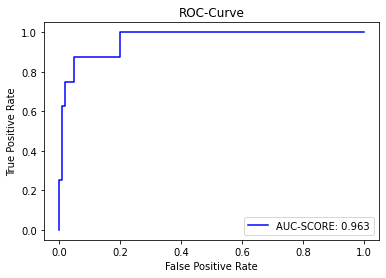

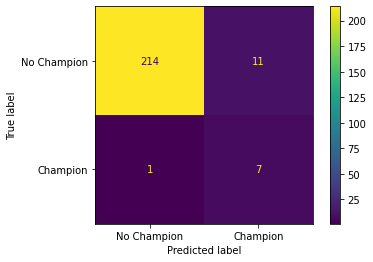

-----------------------------------------------------------------
Finding best hyper-parameters for: balanced_accuracy --------------------------
Best parameters:  {'C': 10, 'class_weight': 'balanced', 'gamma': 'auto'}
Best score:  0.9987179487179487
Accuracy:  0.948
Balanced Accuracy:  0.8527777777777779
Recall:  0.75
Precision:  0.375
F1:  0.5
MCC:  0.5080162567803296


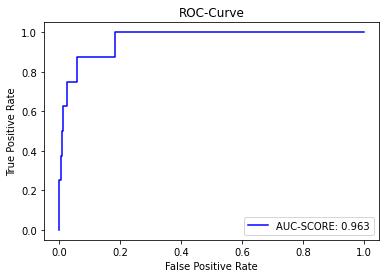

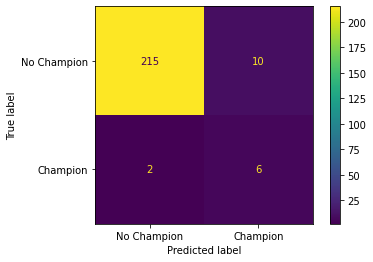

-----------------------------------------------------------------
Finding best hyper-parameters for: make_scorer(matthews_corrcoef) --------------------------
Best parameters:  {'C': 10, 'class_weight': 'balanced', 'gamma': 'auto'}
Best score:  0.9976068156124768
Accuracy:  0.948
Balanced Accuracy:  0.8527777777777779
Recall:  0.75
Precision:  0.375
F1:  0.5
MCC:  0.5080162567803296


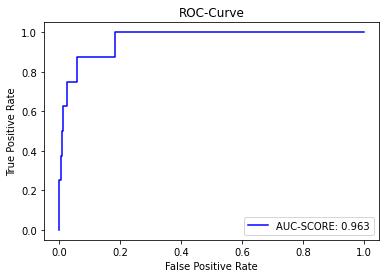

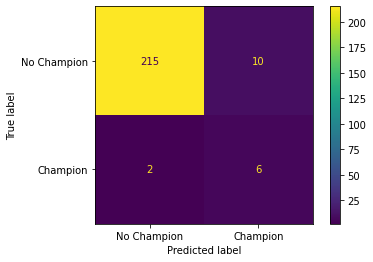

-----------------------------------------------------------------


In [9]:
clf = SVC(random_state=RANDOM_SEED, kernel="rbf", probability=True)

param = {
    "class_weight": ["balanced", None],
    "C": [1, 10, 100, 1e3, 1e4, 1e5],
    "gamma": ["scale", "auto", 1e-5, 1e-4, 1e-3, 1e-2]
}

for score in ['recall', 'balanced_accuracy', make_scorer(matthews_corrcoef)]: 
    grid_search = GridSearchCV(estimator=clf,
                               param_grid=param, 
                               scoring=score,
                               refit=True, 
                               cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED),
                               verbose=0,
                               n_jobs=-3,
                               return_train_score=False)

    print(f'Finding best hyper-parameters for: {score} --------------------------')

    grid_search.fit(train_features, train_labels)
    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)
    
    test_predict = grid_search.predict(test_features)
    test_predict_proba = grid_search.predict_proba(test_features)[:, -1]
    show_all_metrics(test_predict, test_predict_proba, test_labels)
    print("-----------------------------------------------------------------")

### Side Node: If a classifier predict a probability from 0.5 or greater the final result of this classification is 'Champion'. 
- Probability < 0.5 = No Champion
- Probability >= 0.5 = Champion 
- The Probability is multiplied by 100 -> %

In [10]:
clf = SVC(random_state=RANDOM_SEED, kernel="rbf", class_weight='balanced', probability=True, C=1, gamma="scale")
clf.fit(train_features, train_labels)
curr_season_predict = clf.predict(curr_season_features)
curr_season_predict_proba = clf.predict_proba(curr_season_features)[:, -1]

df_curr_season_victory = pd.DataFrame(data=curr_season_original_features, index=None, columns=curr_season_original_columns)
df_curr_season_victory['Team'] = curr_season_team
df_curr_season_victory['Predict_Champion'] = curr_season_predict
df_curr_season_victory['Predict_Proba_Champion'] = curr_season_predict_proba * 100
df_curr_season_victory = df_curr_season_victory.sort_values(by=['Predict_Proba_Champion'], ascending=False, ignore_index=True)
print(df_curr_season_victory[['Team', 'Predict_Proba_Champion']].head(10))

                    Team  Predict_Proba_Champion
0           Phoenix Suns               96.557308
1  Golden State Warriors               56.876920
2         Boston Celtics               23.822601
3        Milwaukee Bucks               12.243525
4              Utah Jazz                2.205830
5      Memphis Grizzlies                1.798189
6             Miami Heat                0.211234
7         Denver Nuggets                0.100469
8          Brooklyn Nets                0.039898
9   Los Angeles Clippers                0.023345


In [11]:
clf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-3, class_weight=None, max_depth=15, n_estimators=30)
clf.fit(train_features, train_labels)
curr_season_predict = clf.predict(curr_season_features)
curr_season_predict_proba = clf.predict_proba(curr_season_features)[:, -1]

df_curr_season_victory = pd.DataFrame(data=curr_season_original_features, index=None, columns=curr_season_original_columns)
df_curr_season_victory['Team'] = curr_season_team
df_curr_season_victory['Predict_Champion'] = curr_season_predict
df_curr_season_victory['Predict_Proba_Champion'] = curr_season_predict_proba * 100
df_curr_season_victory = df_curr_season_victory.sort_values(by=['Predict_Proba_Champion'], ascending=False, ignore_index=True)
print(df_curr_season_victory[['Team', 'Predict_Proba_Champion']].head(10))

                     Team  Predict_Proba_Champion
0   Golden State Warriors               53.333333
1            Phoenix Suns               46.666667
2               Utah Jazz               30.000000
3          Boston Celtics               30.000000
4       Memphis Grizzlies               20.000000
5              Miami Heat               13.333333
6  Minnesota Timberwolves                6.666667
7        Dallas Mavericks                6.666667
8         Milwaukee Bucks                3.333333
9      Philadelphia 76ers                3.333333


### ➤ RandomForest-Top 6 Teams: Probability of becoming NBA Champion
![](pngs/nba_champ_2022.png)


### ➤ Result: The best classifier is the RandomForest, because...
- the balanced accuracy and the confusion matrix are better. 
- the predictions were more in line with the actual playoff results. 
- the RandomForest and his decision making is easier to understand.

In [12]:
df_curr_season_victory.to_csv(NBA_CURRENT_SEASON_PATH, index=False, encoding="utf-8-sig")

df_curr_season_victory_norm = pd.DataFrame(data=curr_season_features, index=None, columns=header_names)
df_curr_season_victory_norm['Team'] = curr_season_team
df_curr_season_victory_norm['Predict_Champion'] = curr_season_predict
df_curr_season_victory_norm['Predict_Proba_Champion'] = curr_season_predict_proba * 100
df_curr_season_victory_norm.sort_values(by=['Predict_Proba_Champion'], ascending=False, inplace=True, ignore_index=True)
df_curr_season_victory_norm.to_csv(NBA_CURRENT_SEASON_ISO_PATH, index=False, encoding="utf-8-sig")

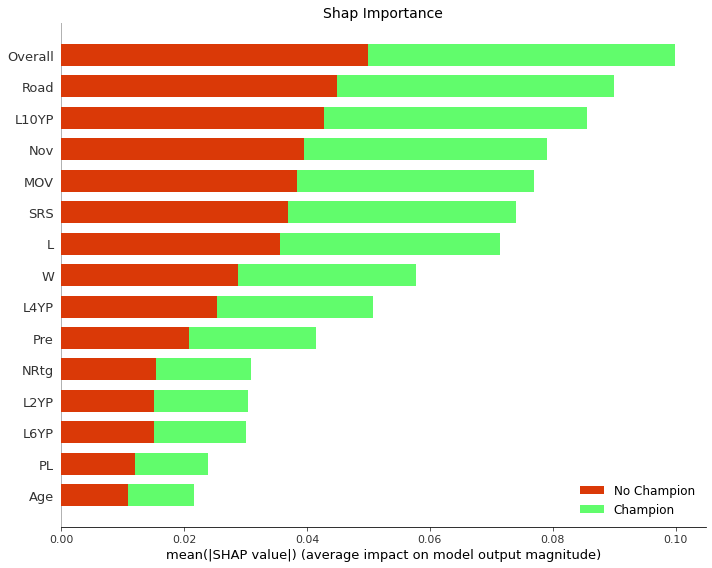

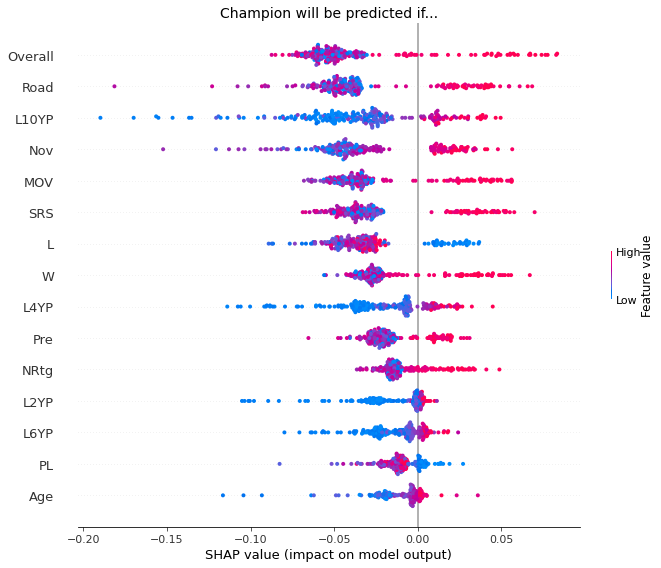

In [14]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(test_features)

shap.summary_plot(shap_values, test_features, plot_type="bar", class_names=label_names, feature_names=header_names, 
                      show=False, max_display=15, color=col.ListedColormap(color_Cha_vs_NoCha), class_inds="original")
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.title("Shap Importance", fontsize=14, loc="center")   
plt.tight_layout()
fig.savefig("pngs/fi_bar.png")
plt.show() 

title = f"{label_names[1]} will be predicted if..."
shap.summary_plot(shap_values[1], test_features, feature_names=header_names, show=False, max_display=15, plot_type="dot")
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.title(title, fontsize=14, loc="center")   
plt.tight_layout()
fig.savefig("pngs/fi_impact.png")
plt.show() 

### ➤ Result: The Feature with the highest impact on the RandomForest is on top. 
#### The RandomForest will predict 'Champion' if...
- the 'Overall' feature have a high value. -> (the team has won an above-average number of games in the regular season)
- the 'Road' feature have a high value. -> (the team has won an above-average number of games away from home)
- the 'L10YP' feature have a high value. -> (the team has excelled performed in the playoffs for the past 10 years -> playoff experience)
- ...

In [15]:
vals = np.abs(shap_values[0]).mean(0) + np.abs(shap_values[1]).mean(0)
feature_importance = pd.DataFrame(list(zip(header_names, vals)), columns=['col_name','feature_importance'])
feature_importance.sort_values(by=['feature_importance'], ascending=False, inplace=True, ignore_index=True)
feature_importance.to_csv(NBA_FI_SEASON_PATH, index=False, encoding="utf-8-sig")

In [16]:
idx_gsw = curr_season_team.index(df_curr_season_victory['Team'][0])
shap_values = explainer.shap_values(curr_season_features[idx_gsw, :])

shap.initjs()
p = shap.force_plot(explainer.expected_value[1], shap_values[1], feature_names=header_names)
shap.save_html('gsw_force_plot.html', p)

### ➤ Golden State Warriors Force Plot -> Why does the RandomForest predict a Champion?
- RED: For a championship speaks specifically(from left to right): good shooting, playoff experience, a lot of wins especially on the road, dominating the opponents
- BLUE: Against a championship speaks specifically(from left to right): bad performace in the past 2-4 years - last months in the season, only few shot attempts 


![](pngs/gsw_force_plot.png)

### ➤ PowerBI HeatTable
![](pngs/heat_table.png)